In [44]:
!pip install git+https://github.com/tensorflow/examples.git
# !pip install -U keras
# !pip install -q tensorflow_datasets
# !pip install -q -U tensorflow-text tensorflow

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-5w9t7_7f
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-5w9t7_7f
  Resolved https://github.com/tensorflow/examples.git to commit 1e000020fcee530f39c3a52ea2c9ebe4de0172e6
  Preparing metadata (setup.py) ... done


In [45]:
import tensorflow as tf
import numpy as np
from IPython.display import clear_output

import datetime

import pathlib
import io
from datetime import datetime

import os
import shutil
import cv2 as cv
import time
import random
import matplotlib.pyplot as plt
# from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape, LeakyReLU, DepthwiseConv2D,Conv2DTranspose)
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

from tensorflow_examples.models.pix2pix import pix2pix

# DATA PIPELINE

In [198]:
train_images = '/kaggle/input/train-dataset/sample/data/'
train_labels = '/kaggle/input/train-dataset/sample/label/'

test_images='/kaggle/input/unseen/test/data/'
test_labels = '/kaggle/input/unseen/test/label/'

classes =['no','brkn','ink','crk']
N_CLASSES = len(classes)
H,W = 416, 416

In [199]:
im_paths = []
xml_paths = []

test_paths = []
test_xml_paths = []

for i in os.listdir(train_images):
    im_paths.append(train_images+i[:-3]+'bmp')
    xml_paths.append(train_labels+i[:-3]+'png')

for i in os.listdir(test_images):
    test_paths.append(test_images+i[:-3]+'bmp')
    test_xml_paths.append(test_labels+i[:-3]+'png')

print(len(im_paths), len(xml_paths))
print(len(test_paths), len(test_xml_paths))



66 66
14 14


In [200]:
val_im_paths = im_paths[int(0.9*len(im_paths)):]
val_xml_paths = xml_paths[int(0.9*len(xml_paths)):]

im_paths = im_paths[:int(0.9*len(im_paths))]
xml_paths = xml_paths[:int(0.9*len(xml_paths))]

print(len(im_paths), len(xml_paths))
print(len(val_im_paths), len(val_xml_paths))

59 59
7 7


In [271]:
train_dataset=tf.data.Dataset.from_tensor_slices((im_paths,xml_paths))
val_dataset=tf.data.Dataset.from_tensor_slices((val_im_paths,val_xml_paths))
test_dataset=tf.data.Dataset.from_tensor_slices((test_paths,test_xml_paths))


def path_to_image(im_path,xml_path):
  img= tf.io.decode_bmp(tf.io.read_file(im_path),3)
  img=tf.cast(tf.image.resize(img, [H,W]),dtype=tf.float32)/255.

  label= tf.io.decode_png(tf.io.read_file(xml_path),1)
  label=tf.cast(tf.image.resize(label, [H,W]),dtype=tf.float32)/255.
  label = tf.where((label != 0) & (label != 1), 1.0, label)
  # label = label[...,0]
  # zero_mask = tf.zeros_like(label)
  # label = tf.stack([zero_mask,label],axis=2)
    
  return tf.convert_to_tensor(img,dtype = tf.float32),tf.convert_to_tensor(label,dtype = tf.float32)

train_dataset=train_dataset.map(path_to_image)
val_dataset=val_dataset.map(path_to_image)
test_dataset=test_dataset.map(path_to_image)

In [204]:
number=0

(416, 416, 1)
All pixels are either 0 or 1


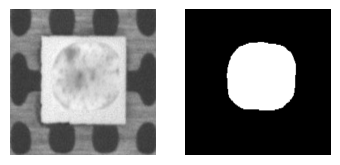

In [272]:
for i, j in test_dataset.skip(number):
    plt.subplot(1, 3, 1)
    plt.imshow(i.numpy())
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    print(j.numpy().shape)
    plt.imshow(j.numpy()[...,0], cmap='gray')
    plt.axis('off')

    # plt.subplot(1, 3, 3)
    # print(j.numpy().shape)
    # plt.imshow(j.numpy()[...,1], cmap='gray')
    # plt.axis('off')
    
    # Convert tensor to NumPy array
    j_numpy = j.numpy()
    
    # Check for pixels that are not 0 or 1
    non_binary_pixels = j_numpy[(j_numpy != 0) & (j_numpy != 1)]
    if non_binary_pixels.size > 0:
        print("Non-binary pixels found:", non_binary_pixels)
    else:
        print("All pixels are either 0 or 1")
    
    break
number+=1

In [273]:
train_dataset = train_dataset.concatenate(test_dataset)

In [274]:
print(len(train_dataset))

73


In [276]:
transforms = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    # A.GaussNoise(var_limit=(50.0, 80.0), p=0.5),
    A.RandomCrop(
         width=np.random.randint(int(0.9*H),H),
         height=np.random.randint(int(0.9*W),W), p= 0.5),
    A.RandomScale(scale_limit=0.1, interpolation=cv.INTER_LANCZOS4,p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Resize(H,W),
])

def aug_albument(image,label):
  augmented=transforms(image=image,mask=label)
  return augmented['image'],augmented['mask']

def process_data(image,label):
    aug_image,aug_label = tf.numpy_function(func=aug_albument, inp=[image,label], Tout=[tf.float32,tf.float32])
    aug_image.set_shape([H, W, 3])
    aug_label.set_shape([H, W, 1])
    return tf.convert_to_tensor(aug_image,dtype = tf.float32) , tf.convert_to_tensor(aug_label,dtype = tf.float32) 

In [277]:
train_dataset=train_dataset.map(process_data)
# val_dataset = val_dataset.map(process_data)

In [278]:
train_dataset=(
  train_dataset
  .shuffle(buffer_size=100, reshuffle_each_iteration=True).
  batch(4).
  prefetch(tf.data.AUTOTUNE)
)

val_dataset=(
  val_dataset.
  batch(4).
  prefetch(tf.data.AUTOTUNE)
)
# test_dataset=(
#   test_dataset.
#   batch(1).
#   prefetch(tf.data.AUTOTUNE)
# )

(416, 416, 1)
All pixels are either 0 or 1


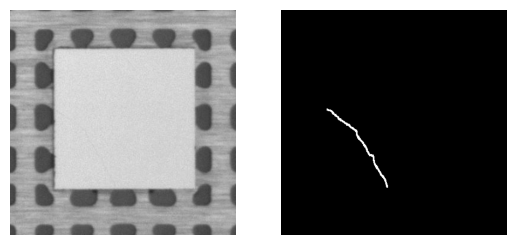

In [279]:
for i, j in train_dataset.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(i[0].numpy())
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    print(j[0].numpy().shape)
    plt.imshow(j[0].numpy(), cmap='gray')
    plt.axis('off')
    
    # Convert tensor to NumPy array
    j_numpy = j.numpy()
    
    # Check for pixels that are not 0 or 1
    non_binary_pixels = j_numpy[(j_numpy != 0) & (j_numpy != 1)]
    if non_binary_pixels.size > 0:
        print("Non-binary pixels found:", non_binary_pixels)
    else:
        print("All pixels are either 0 or 1")
    
    break


# MODEL DESIGN

In [15]:
# BOTTLE RES BOCK UNET

def bottle_res_block(inputs, num_filters1,num_filters2,drop_out=False):
    x = Conv2D(num_filters1, 1, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("leaky_relu")(x)

    x = DepthwiseConv2D(3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("leaky_relu")(x)
    
    x = Conv2D(num_filters2, 1, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network

    x = tf.keras.layers.Concatenate()([inputs,x])
    
    if drop_out == True:
        x = tf.keras.layers.Dropout(0.5)(x)
    return x

def model_create():
    inputs = tf.keras.layers.Input(shape=(H,W,3))
    x = tf.keras.layers.Conv2D(32,3,padding='same',activation='leaky_relu')(inputs)
    route1 = x
    x = tf.keras.layers.MaxPool2D((3,3),(2,2),padding='same')(x)
    route2 = x
    
    x = bottle_res_block(x,64,16)
    x = bottle_res_block(x,64,16)
    x = tf.keras.layers.MaxPool2D((3,3),(2,2),padding='same')(x)
    route3 = x
    
    x = bottle_res_block(x,128,32)
    x = bottle_res_block(x,128,32)
    x = tf.keras.layers.MaxPool2D((3,3),(2,2),padding='same')(x)
    route4 = x
    
    x = bottle_res_block(x,192,48)
    x = bottle_res_block(x,192,48)
    route5 = x
    
    x = bottle_res_block(x,256,64)
    x = bottle_res_block(x,512,128)
    x = bottle_res_block(x,256,64,True)
    
    x = Conv2DTranspose(128,3,1,padding='same')(x)
    x = tf.keras.layers.Concatenate()([x,route5])
    x = bottle_res_block(x,128,32)
    
    x = Conv2DTranspose(128,3,1,padding='same')(x)
    x = tf.keras.layers.Concatenate()([x,route4])
    x = bottle_res_block(x,128,32)
    
    x = Conv2DTranspose(64,3,2,padding='same')(x)
    x = tf.keras.layers.Concatenate()([x,route3])
    x = bottle_res_block(x,128,32)
    
    x = Conv2DTranspose(32,3,2,padding='same')(x)
    x = tf.keras.layers.Concatenate()([x,route2])
    x = bottle_res_block(x,64,16)
    
    x = Conv2DTranspose(32,3,2,padding='same')(x)
    x = tf.keras.layers.Concatenate()([x,route1])
    x = Conv2D(32,3,padding='same',activation='leaky_relu')(x)
    decoded = Conv2D(1, 1, padding="same", activation="sigmoid")(x)
    
    model = Model(inputs,decoded,name='BrB-UNet')
    return model

In [49]:
# UNET from tensorflow
base_model = tf.keras.applications.MobileNetV2(input_shape=[416, 416, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def model_create(output_channels:int = 2):
  inputs = tf.keras.layers.Input(shape=[416, 416, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

/tmp/ipykernel_30/2748588787.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=[416, 416, 3], include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [294]:
model = model_create()
# model.summary()

In [292]:
iou = tf.keras.metrics.OneHotIoU(
    num_classes=2,
    target_class_ids=[1],
    name=None,
    dtype=None,
    ignore_class=None,
    sparse_y_pred=False,
    axis=-1
)

In [295]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy',iou]
)


In [100]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [101]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      tf.print(image.shape)
      if len(image.shape) == 4:
          display([image[0], mask[0], create_mask(pred_mask)])
      elif len(image.shape) == 3:
          display([image, mask, create_mask(pred_mask)])
  else:
      for i,j in val_dataset.take(1):
        if len(i.shape) == 4:
            display([i[0], j[0],create_mask(model.predict(i))])
        elif len(i.shape) == 3:
            display([i, j,create_mask(model.predict(i))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
TensorShape([1, 416, 416, 3])


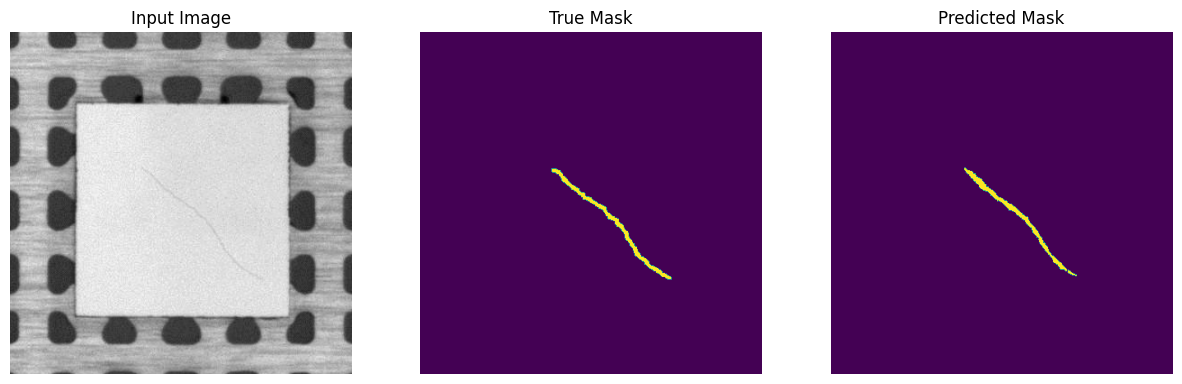

In [234]:
show_predictions(val_dataset,1)

In [102]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [288]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='kaggle/working/model.weights.h5',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


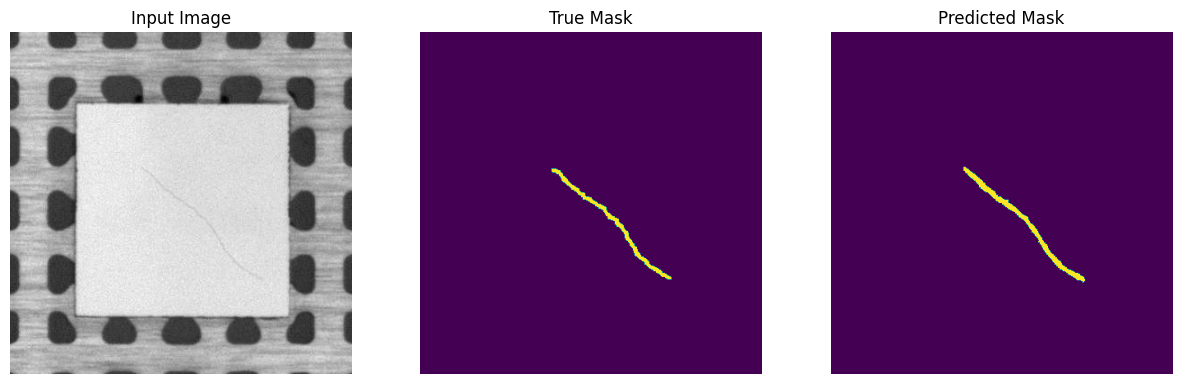


Sample Prediction after epoch 50


Epoch 50: loss improved from 0.01279 to 0.01277, saving model to kaggle/working/model.weights.h5
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.9959 - loss: 0.0125 - one_hot_io_u_1: 0.0000e+00 - val_accuracy: 0.9970 - val_loss: 0.0123 - val_one_hot_io_u_1: 0.0000e+00


In [296]:
EPOCHS = 50
# VAL_SUBSPLITS = 5
# VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          # steps_per_epoch=STEPS_PER_EPOCH,
                          # validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset,
                          callbacks=[DisplayCallback(),checkpoint],
                          )

In [297]:
temp_history= model_history

In [298]:
for key in temp_history.history.keys():
    model_history.history[key] = temp_history.history[key] + model_history.history[key]
temp_history= model_history

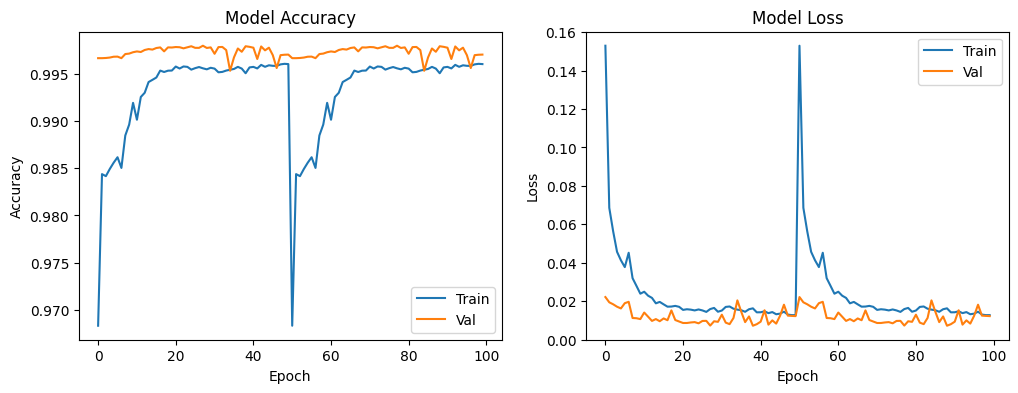

In [299]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='lower right')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='upper right')
plt.savefig('test_accuracy_loss.png', dpi=120, bbox_inches='tight')
plt.show()


In [111]:
model.evaluate(test_dataset)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.9816 - loss: 0.0964


[0.14461790025234222, 0.9744573831558228]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
TensorShape([4, 416, 416, 3])


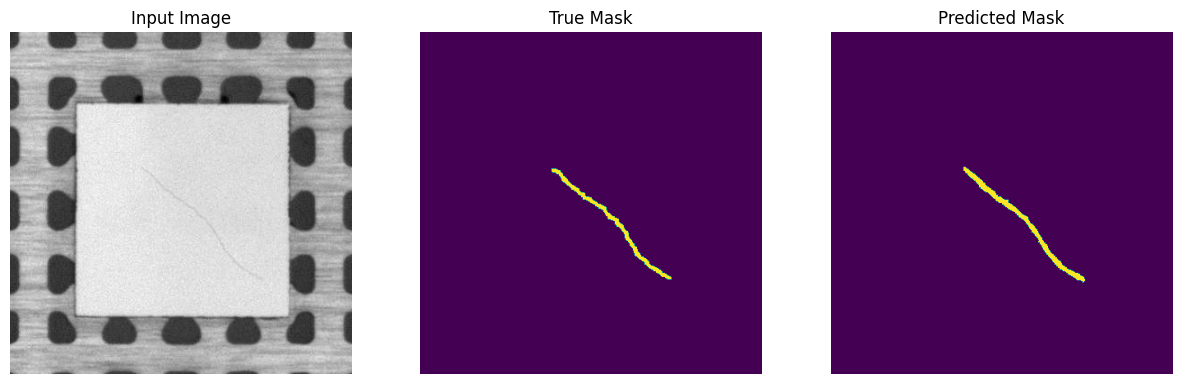

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
TensorShape([3, 416, 416, 3])


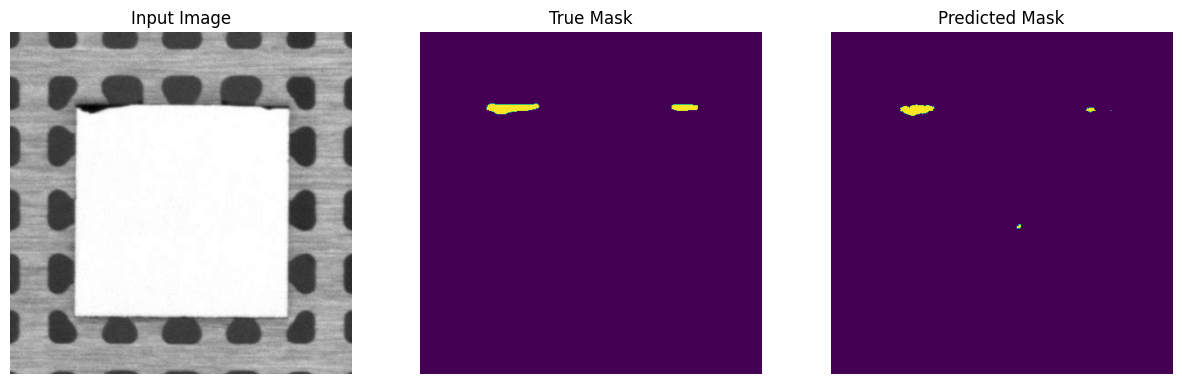

In [300]:
show_predictions(val_dataset,7)

In [133]:
images='/kaggle/input/new1-dataset/dataset/defect_images/dataset1/test/image/'
paths = []

for i in os.listdir(images):
    paths.append(images+i[:-3]+'bmp')
print(len(paths))



273


In [136]:
def path_to_image_unlabeled(im_path,xml_path):
  img= tf.io.decode_bmp(tf.io.read_file(im_path),3)
  img=tf.cast(tf.image.resize(img, [H,W]),dtype=tf.float32)/255.

    
  return tf.convert_to_tensor(img,dtype = tf.float32),tf.convert_to_tensor(img,dtype = tf.float32)

In [137]:
unlabeled=tf.data.Dataset.from_tensor_slices((paths,paths))
unlabeled=unlabeled.map(path_to_image_unlabeled)
unlabeled=(
  unlabeled.
  batch(1).
  prefetch(tf.data.AUTOTUNE)
)

In [316]:
res_img = []

In [317]:
def display_(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Predicted Mask', 'Overlay']

  for i in range(len(display_list)):
    res_img.append(tf.keras.utils.array_to_img(display_list[i]))
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  # plt.show()

def show_predictions_unlabeled(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      tf.print(image.shape)
        
      mask = create_mask(pred_mask)
      color_mask = tf.cast(tf.stack([mask[...,0],mask[...,0],mask[...,0]],axis=2),dtype=tf.float32)
      tf.print(color_mask.shape)
      color_mask = tf.where(mask!=0,tf.constant([0.5,0.5,0.0]),color_mask,)
      tf.print(mask.shape)
      display_([image[0], mask, (image[0]*0.9+(1-0.1)*color_mask)])
    plt.savefig('result.png', dpi=400, bbox_inches='tight')
    plt.show()
  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
TensorShape([1, 416, 416, 3])
TensorShape([416, 416, 3])
TensorShape([416, 416, 1])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
TensorShape([1, 416, 416, 3])
TensorShape([416, 416, 3])
TensorShape([416, 416, 1])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
TensorShape([1, 416, 416, 3])
TensorShape([416, 416, 3])
TensorShape([416, 416, 1])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
TensorShape([1, 416, 416, 3])
TensorShape([416, 416, 3])
TensorShape([416, 416, 1])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
TensorShape([1, 416, 416, 3])
TensorShape([416, 416, 3])
TensorShape([416, 416, 1])


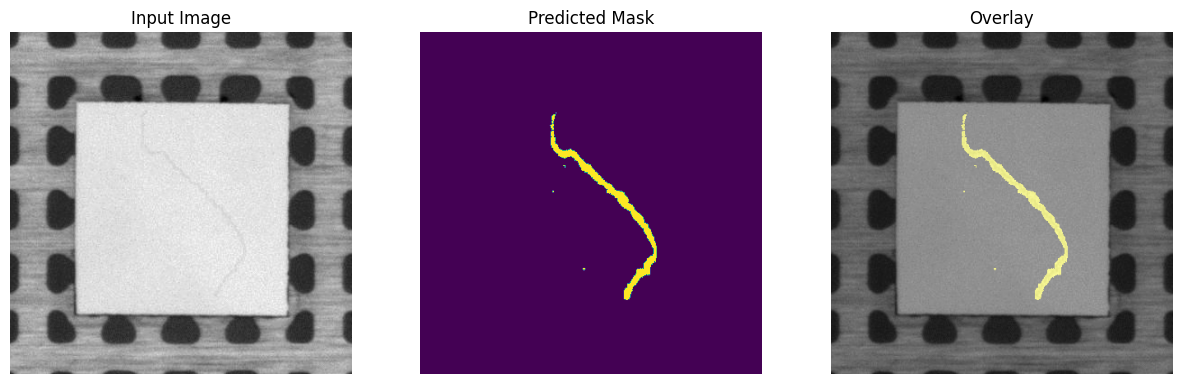

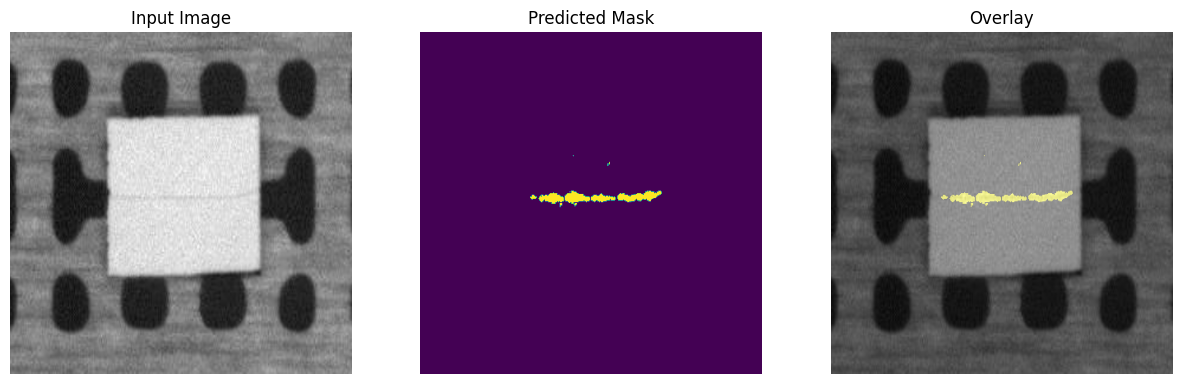

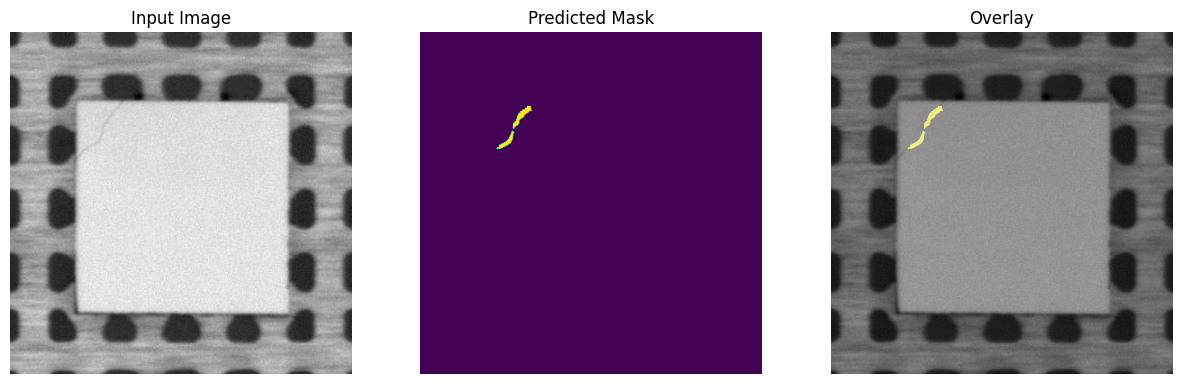

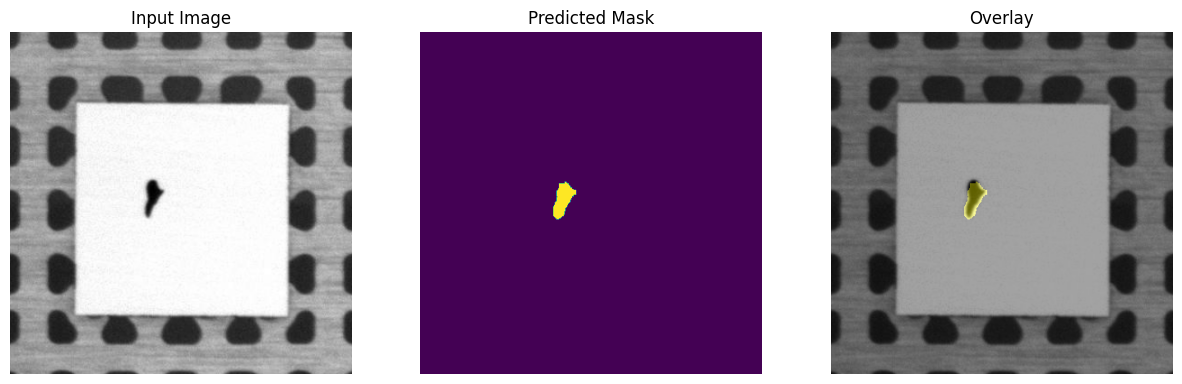

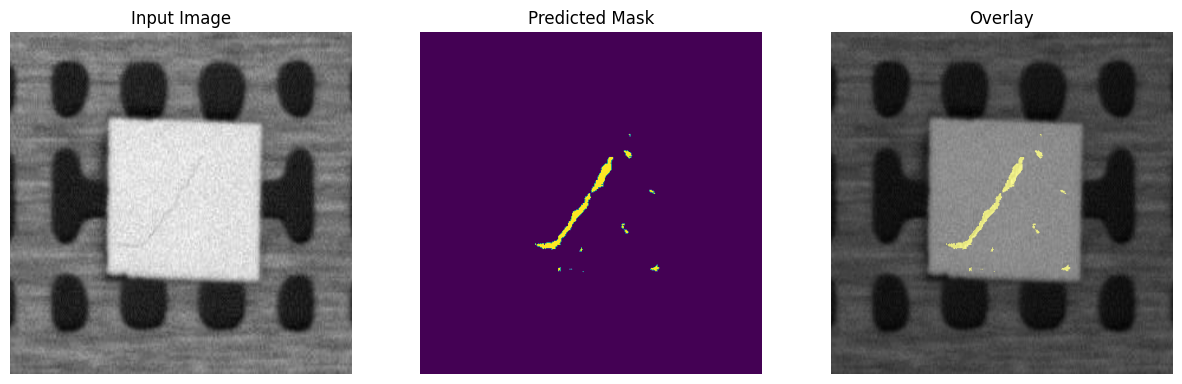

In [318]:
show_predictions_unlabeled(unlabeled.skip(30),5)

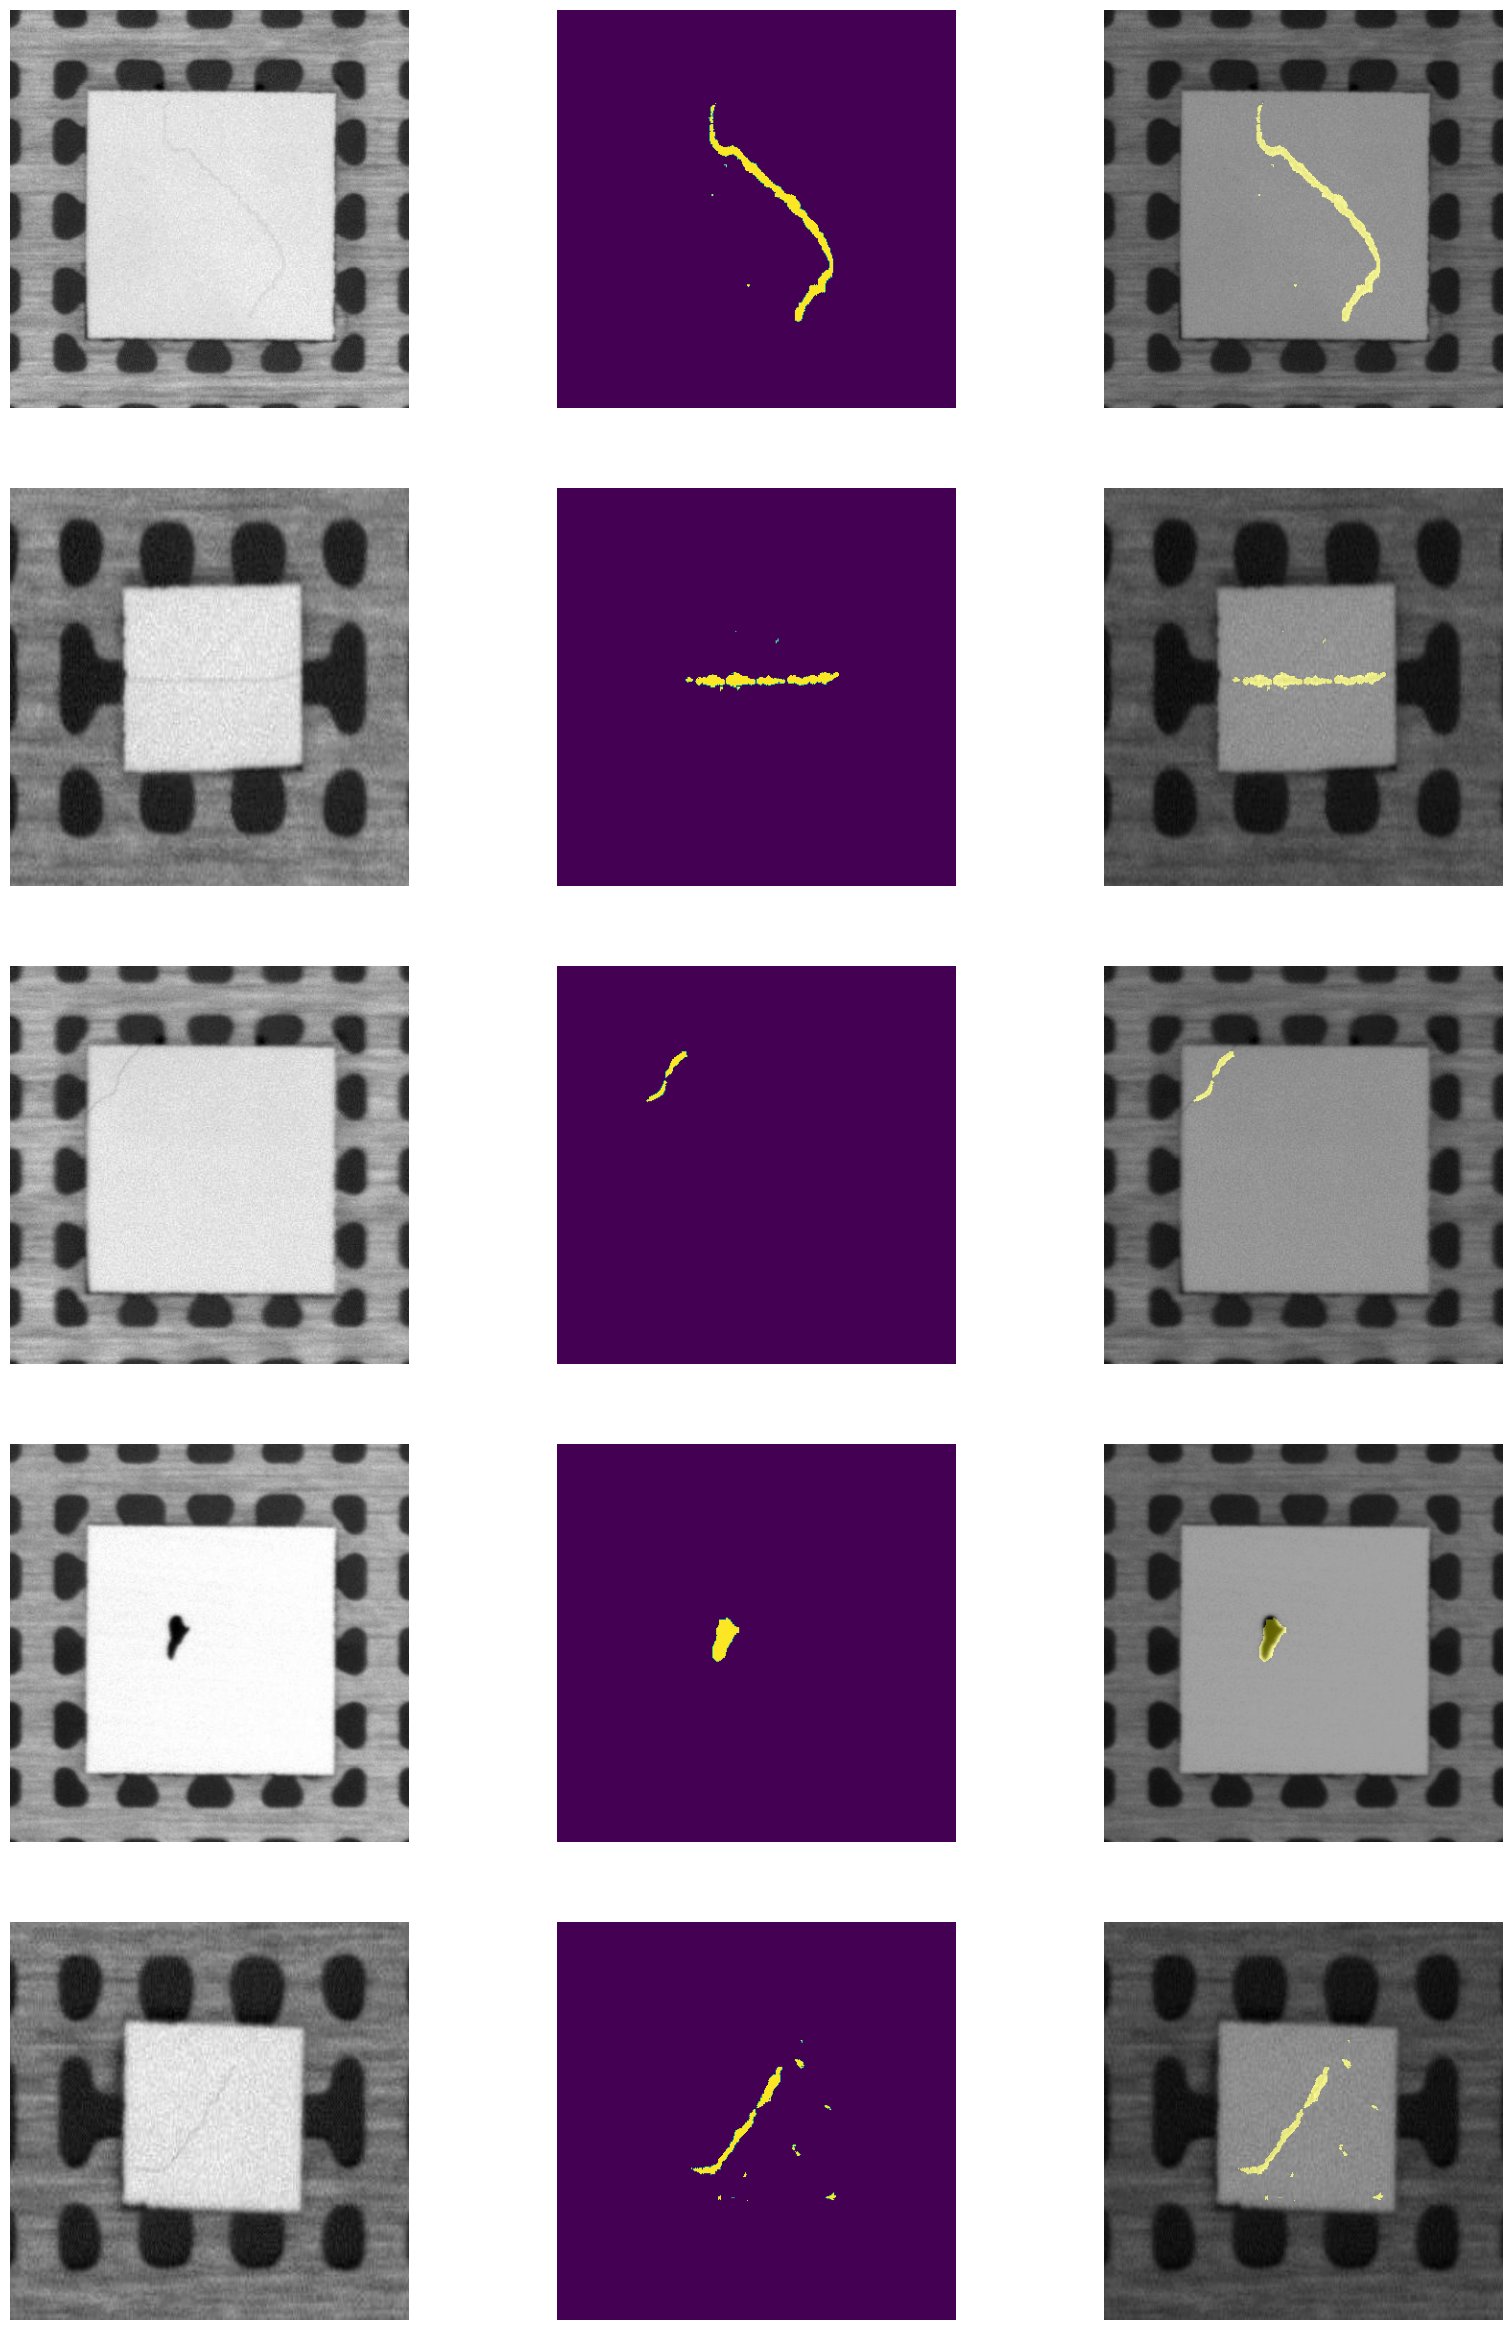

In [333]:
plt.figure(figsize=(20,30))
for index in range(len(res_img)):
    plt.subplot(5,3,index+1)
    plt.imshow(res_img[index])
    plt.axis('off')
plt.savefig('result.png', dpi=400, bbox_inches='tight')
plt.show()